In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
from resnet import ResNet18
import time
import pickle
import os
import numpy as np

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [8]:
EPOCH = 20   #遍历数据集次数
BATCH_SIZE = 128      #批处理尺寸(batch_size)
LR = 0.001        #学习率 
Milestones=[135,185]
Debug=False

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='/root/GanLuo/pytorch-cifar10-resnet18/cifar-10-python', train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/root/GanLuo/pytorch-cifar10-resnet18/cifar-10-python', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResNet18().to(device)
# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=Milestones,gamma = 0.1)

In [19]:
# 模型定义-ResNet
net = ResNet18().to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR)  # 优化方式
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=Milestones, gamma=0.1)

#writer = SummaryWriter("./logs")

best_acc = 85  # 初始化最佳测试准确率
print("Start Training, Resnet-18!")

EPOCH=50

Train_Accuracy=[]
Train_Loss=[]
Test_Accuracy=[]
Test_Loss=[]

for epoch in range(EPOCH):
    train_loss = 0.0
    train_accu = 0.0
    val_loss = 0.0
    val_accu = 0.0

    scheduler.step()
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0
    begin = time.time()

    # 训练阶段
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        if Debug:
            print("[Epoch:{}/{}, Batch:{}/{}] Loss: {:.3f} | Acc: {:.3f}%".format(epoch + 1, EPOCH, i + 1, int(len(trainset) / BATCH_SIZE), sum_loss / (i + 1), 100. * correct / total))

    train_loss = sum_loss / int(len(trainset) / BATCH_SIZE)
    train_accu = 100. * correct / total

    Train_Accuracy.append(train_accu)
    Train_Loss.append(train_loss)

    # 测试阶段
    with torch.no_grad():
        sum_loss = 0.0
        correct = 0.0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()

    val_loss = sum_loss / int(len(testset) / BATCH_SIZE)
    val_accu = 100. * correct / total
    Test_Accuracy.append(val_accu)
    Test_Loss.append(val_loss)
    end = time.time()

    # 打印和记录每轮结果
    print("[Epoch:{}/{}] Train Loss: {:.3f} | Train Acc: {:.3f}% Test Loss: {:.3f} | Test Acc: {:.3f}% Cost time: {:.2f} min".format(epoch + 1, EPOCH, train_loss, train_accu, val_loss, val_accu, (end - begin) / 60.0))



    # 保存模型
    #torch.save(net.state_dict(), './net_%03d.pth' % (epoch + 1))

    # 更新最佳准确率
    if val_accu > best_acc:
        with open("best_acc.txt", "w") as f3:
            f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, val_accu))
        best_acc = val_accu

print("Training Finished, Total EPOCH=%d" % EPOCH)


Start Training, Resnet-18!


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[Epoch:1/50] Train Loss: 2.065 | Train Acc: 23.962% Test Loss: 2.326 | Test Acc: 33.030% Cost time: 0.12 min
[Epoch:2/50] Train Loss: 1.751 | Train Acc: 35.342% Test Loss: 2.083 | Test Acc: 39.570% Cost time: 0.12 min
[Epoch:3/50] Train Loss: 1.608 | Train Acc: 40.602% Test Loss: 1.972 | Test Acc: 42.770% Cost time: 0.12 min
[Epoch:4/50] Train Loss: 1.516 | Train Acc: 44.012% Test Loss: 1.879 | Test Acc: 46.030% Cost time: 0.12 min
[Epoch:5/50] Train Loss: 1.442 | Train Acc: 47.010% Test Loss: 1.751 | Test Acc: 49.390% Cost time: 0.12 min
[Epoch:6/50] Train Loss: 1.373 | Train Acc: 49.728% Test Loss: 1.703 | Test Acc: 51.100% Cost time: 0.12 min
[Epoch:7/50] Train Loss: 1.312 | Train Acc: 52.316% Test Loss: 1.624 | Test Acc: 53.870% Cost time: 0.12 min
[Epoch:8/50] Train Loss: 1.261 | Train Acc: 54.438% Test Loss: 1.564 | Test Acc: 55.480% Cost time: 0.12 min
[Epoch:9/50] Train Loss: 1.206 | Train Acc: 56.808% Test Loss: 1.521 | Test Acc: 57.370% Cost time: 0.12 min
[Epoch:10/50] Train

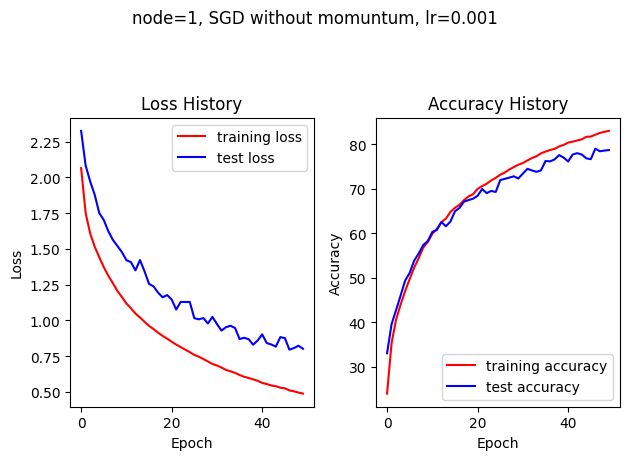

In [20]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'node=1, SGD without momuntum, lr={LR}')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

In [17]:
# 模型定义-ResNet
net = ResNet18().to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)  # 优化方式
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=Milestones, gamma=0.1)

#writer = SummaryWriter("./logs")

best_acc = 85  # 初始化最佳测试准确率
print("Start Training, Resnet-18!")

EPOCH=50

Train_Accuracy=[]
Train_Loss=[]
Test_Accuracy=[]
Test_Loss=[]

for epoch in range(EPOCH):
    train_loss = 0.0
    train_accu = 0.0
    val_loss = 0.0
    val_accu = 0.0

    scheduler.step()
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0
    begin = time.time()

    # 训练阶段
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        if Debug:
            print("[Epoch:{}/{}, Batch:{}/{}] Loss: {:.3f} | Acc: {:.3f}%".format(epoch + 1, EPOCH, i + 1, int(len(trainset) / BATCH_SIZE), sum_loss / (i + 1), 100. * correct / total))

    train_loss = sum_loss / int(len(trainset) / BATCH_SIZE)
    train_accu = 100. * correct / total

    Train_Accuracy.append(train_accu)
    Train_Loss.append(train_loss)

    # 测试阶段
    with torch.no_grad():
        sum_loss = 0.0
        correct = 0.0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()

    val_loss = sum_loss / int(len(testset) / BATCH_SIZE)
    val_accu = 100. * correct / total
    Test_Accuracy.append(val_accu)
    Test_Loss.append(val_loss)
    end = time.time()

    # 打印和记录每轮结果
    print("[Epoch:{}/{}] Train Loss: {:.3f} | Train Acc: {:.3f}% Test Loss: {:.3f} | Test Acc: {:.3f}% Cost time: {:.2f} min".format(epoch + 1, EPOCH, train_loss, train_accu, val_loss, val_accu, (end - begin) / 60.0))



    # 保存模型
    #torch.save(net.state_dict(), './net_%03d.pth' % (epoch + 1))

    # 更新最佳准确率
    if val_accu > best_acc:
        with open("best_acc.txt", "w") as f3:
            f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, val_accu))
        best_acc = val_accu

print("Training Finished, Total EPOCH=%d" % EPOCH)


Start Training, Resnet-18!


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[Epoch:1/50] Train Loss: 1.639 | Train Acc: 39.710% Test Loss: 1.832 | Test Acc: 48.150% Cost time: 0.12 min
[Epoch:2/50] Train Loss: 1.209 | Train Acc: 56.222% Test Loss: 1.403 | Test Acc: 60.910% Cost time: 0.12 min
[Epoch:3/50] Train Loss: 1.000 | Train Acc: 64.358% Test Loss: 1.369 | Test Acc: 62.700% Cost time: 0.12 min
[Epoch:4/50] Train Loss: 0.863 | Train Acc: 69.506% Test Loss: 1.113 | Test Acc: 70.000% Cost time: 0.12 min
[Epoch:5/50] Train Loss: 0.753 | Train Acc: 73.396% Test Loss: 1.024 | Test Acc: 72.940% Cost time: 0.12 min
[Epoch:6/50] Train Loss: 0.673 | Train Acc: 76.466% Test Loss: 0.884 | Test Acc: 76.230% Cost time: 0.12 min
[Epoch:7/50] Train Loss: 0.615 | Train Acc: 78.586% Test Loss: 0.935 | Test Acc: 75.350% Cost time: 0.12 min
[Epoch:8/50] Train Loss: 0.562 | Train Acc: 80.660% Test Loss: 0.822 | Test Acc: 77.870% Cost time: 0.12 min
[Epoch:9/50] Train Loss: 0.520 | Train Acc: 81.872% Test Loss: 0.813 | Test Acc: 78.990% Cost time: 0.12 min
[Epoch:10/50] Train

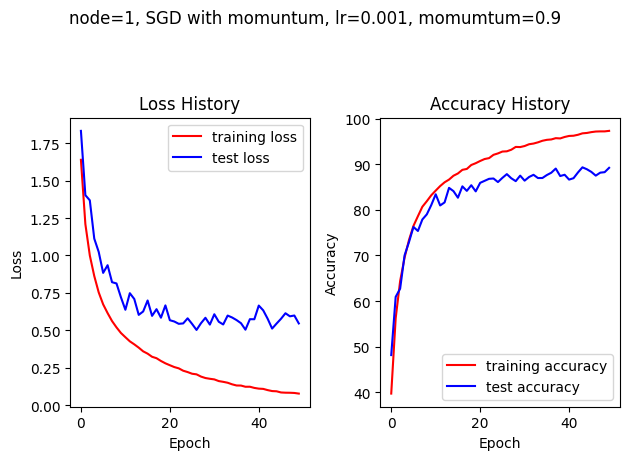

In [18]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'node=1, SGD with momuntum, lr={LR}, momumtum=0.9')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()